In [ ]:
# Graph Networks

In [ ]:
# 1 Grid with 2 points and 2 obs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Gitterpunkte
x0 = 0.0
x1 = np.pi

# Zwei Beobachtungspunkte
x_obs1 = np.pi / 4
x_obs2 = 3 * np.pi / 4

# Ziel-Funktion: sin(x + phase)
phase = 0.5
def f(x): return torch.sin(torch.tensor(x) + phase)

# Knoten: [x, val, mask]
# Index: 0 = x0, 1 = x1, 2 = obs1, 3 = obs2
node_pos = torch.tensor([x0, x1, x_obs1, x_obs2])
node_val = torch.tensor([0.0, 0.0, f(x_obs1), f(x_obs2)])
node_mask = torch.tensor([0.0, 0.0, 1.0, 1.0])
x_feat = torch.stack([node_pos, node_val, node_mask], dim=1)

# Kanten: jede Beobachtung verbindet sich mit beiden Gitterpunkten
edge_index = torch.tensor([
    [2, 2, 3, 3, 0, 1, 0, 1],  # from
    [0, 1, 0, 1, 2, 2, 3, 3],  # to
], dtype=torch.long)

# Ziel: f(0), f(pi)
y_target = torch.tensor([f(x0), f(x1)])

# Einfaches GNN
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        x = self.self_lin(x) + self.neigh_lin(agg)
        return F.relu(x)
class MiniGNN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.gnn1 = GNNLayer(dim)
        self.gnn2 = GNNLayer(dim)
        self.out = nn.Linear(dim, 1)

    def forward(self, x, edge_index):
        x = self.gnn1(x, edge_index)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)

# Training
model = MiniGNN(dim=3)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    model.train()
    pred = model(x_feat, edge_index)
    loss = F.mse_loss(pred[:2], y_target)  # nur Gitterpunkte zählen
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Evaluation
model.eval()
with torch.no_grad():
    pred = model(x_feat, edge_index)
    print("\nGitterpunkt-Vorhersagen:")
    print(f"f(0)  predicted: {pred[0].item():.4f}, true: {y_target[0].item():.4f}")
    print(f"f(pi) predicted: {pred[1].item():.4f}, true: {y_target[1].item():.4f}")

Epoch 0: Loss = 0.338665
Epoch 100: Loss = 0.000011
Epoch 200: Loss = 0.000000
Epoch 300: Loss = 0.000000
Epoch 400: Loss = 0.000000

Gitterpunkt-Vorhersagen:
f(0)  predicted: 0.4794, true: 0.4794
f(pi) predicted: -0.4794, true: -0.4794


In [ ]:
# 2 One function, random obs

Epoch 0, Loss: 0.43250
Epoch 50, Loss: 0.00550
Epoch 100, Loss: 0.00287
Epoch 150, Loss: 0.00090
Epoch 200, Loss: 0.00005
Epoch 250, Loss: 0.00002


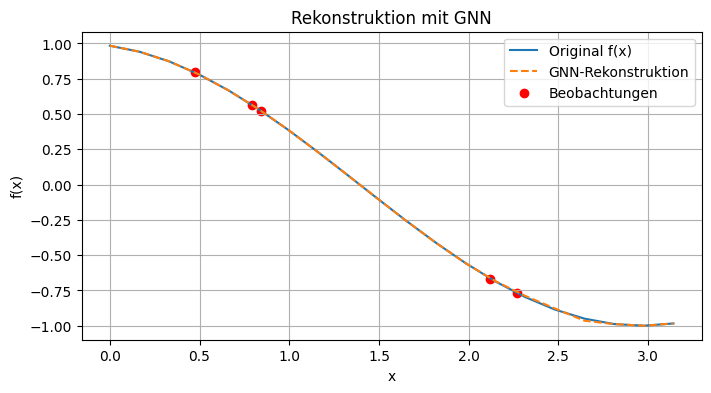

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 20         # Gitterpunkte
M = 5          # Beobachtungspunkte
num_epochs = 300
lr = 0.01

x_grid = torch.linspace(0, np.pi, N)

# Ziel-Funktion
phase = torch.rand(1).item() * np.pi
def f(x): return torch.sin(x + phase)

# Beobachtungspunkte zufällig
obs_x = torch.sort(torch.rand(M) * np.pi).values
obs_y = f(obs_x)

# Alle Knotenpositionen
node_pos = torch.cat([x_grid, obs_x])
node_val = torch.cat([torch.zeros(N), obs_y])
node_mask = torch.cat([torch.zeros(N), torch.ones(M)])
x_feat = torch.stack([node_pos, node_val, node_mask], dim=1)

# Knotenindizes
num_nodes = N + M

# Kanten: Gitterknoten <-> Nachbarn
edges = []
for i in range(N - 1):
    edges.append((i, i + 1))
    edges.append((i + 1, i))

# Beobachtungsknoten mit 2 nächsten Gitterpunkten verbinden
for j in range(M):
    obs = obs_x[j]
    dists = torch.abs(x_grid - obs)
    idx = torch.topk(-dists, 2, largest=False).indices
    for i in idx:
        edges.append((N + j, i.item()))
        edges.append((i.item(), N + j))

# Adjazenzmatrix
edge_index = torch.tensor(edges).T

# Zielwerte auf Gitter
y_target = f(x_grid)

# Self + Neighbour GNN Layer
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        return F.relu(self.self_lin(x) + self.neigh_lin(agg))

# Modell
class GNN(nn.Module):
    def __init__(self, dim=3, hidden=64):
        super().__init__()
        self.input_proj = nn.Linear(dim, hidden)
        self.gnn1 = GNNLayer(hidden)
        self.gnn2 = GNNLayer(hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.input_proj(x))
        x = self.gnn1(x, edge_index)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)
# Training
model = GNN()
opt = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    pred = model(x_feat, edge_index)[:N]  # nur Gitterpunkte
    loss = F.mse_loss(pred, y_target)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

# Plot Ergebnis
model.eval()
with torch.no_grad():
    pred = model(x_feat, edge_index)[:N]

plt.figure(figsize=(8, 4))
plt.plot(x_grid, y_target, label="Original f(x)")
plt.plot(x_grid, pred, '--', label="GNN-Rekonstruktion")
plt.scatter(obs_x, obs_y, color='red', label="Beobachtungen")
plt.title("Rekonstruktion mit GNN")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 3 Function with N grid points and
# each Mth is observed, reconstruct

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 30          # Gitterpunkte
M = 3           # Nur jeder M-te Punkt ist beobachtet
K = 2           # K Nachbarn
num_epochs = 201
num_samples = 200
lr = 0.01

x_grid = torch.linspace(0, np.pi, N)

# GNN-Layer wie zuvor
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        return F.relu(self.self_lin(x) + self.neigh_lin(agg))

class GNN(nn.Module):
    def __init__(self, in_dim=3, hidden=64):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden)
        self.gnn1 = GNNLayer(hidden)
        self.gnn2 = GNNLayer(hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.input_proj(x))
        x = self.gnn1(x, edge_index)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)

model = GNN()
opt = torch.optim.Adam(model.parameters(), lr=lr)

# Baue K-Nachbar-Kanten (immer gleich)
for i in range(N):
    edges.append((i, i))  # Self-Loop
    for k in range(1, K + 1):
        if i - k >= 0:
            edges.append((i, i - k))
        if i + k < N:
            edges.append((i, i + k))

# Training auf vielen Funktionen
for epoch in range(num_epochs):
    losses = []
    for _ in range(num_samples):
        # Zufällige Funktion: sin oder cos mit zufälliger Phase
        phase = torch.rand(1).item() * np.pi
        f_type = torch.randint(0, 2, (1,)).item()
        if f_type == 0:
            f = lambda x: torch.sin(x + phase)
        else:
            f = lambda x: torch.cos(x + phase)

        y_true = f(x_grid)

        # Maske: jeder M-te Punkt
        mask = torch.zeros(N)
        mask[::M] = 1.0
        obs_y = y_true * mask

        # Features
        x_feat = torch.stack([x_grid, obs_y, mask], dim=1)

        # Training
        model.train()
        pred = model(x_feat, edge_index)
        loss = F.mse_loss(pred, y_true)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {np.mean(losses):.6f}")

Epoch 0: Loss = 0.381584
Epoch 50: Loss = 0.002450
Epoch 100: Loss = 0.002053
Epoch 150: Loss = 0.001984
Epoch 200: Loss = 0.002297


In [ ]:
# Testing it

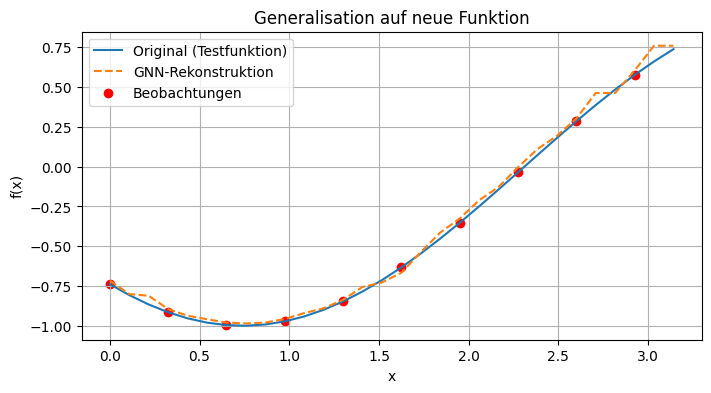

In [ ]:
# Neue Funktion (z. B. Cosinus mit unbekannter Phase)
phi = np.pi * torch.rand(1).item()
f_test = lambda x: torch.cos(x + phi)
y_test = f_test(x_grid)

mask = torch.zeros(N)
mask[::M] = 1.0
obs = y_test * mask
x_feat = torch.stack([x_grid, obs, mask], dim=1)

model.eval()
with torch.no_grad():
    pred = model(x_feat, edge_index)

plt.figure(figsize=(8, 4))
plt.plot(x_grid, y_test, label="Original (Testfunktion)")
plt.plot(x_grid, pred, '--', label="GNN-Rekonstruktion")
plt.scatter(x_grid[::M], y_test[::M], color='red', label="Beobachtungen")
plt.title("Generalisation auf neue Funktion")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 4 auf [0, 2 pi] testen

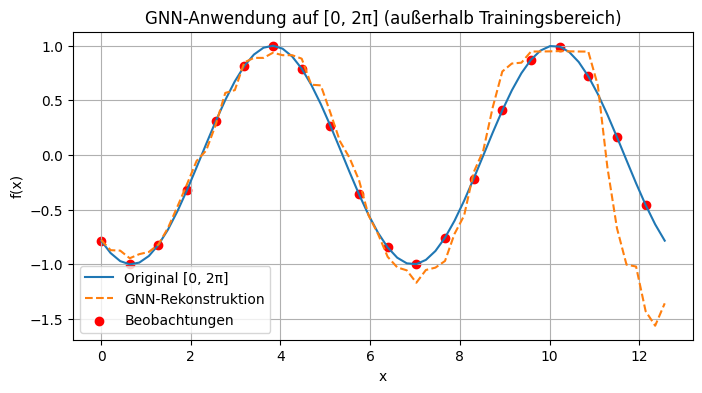

In [ ]:
# Neuer Gitterbereich: [0, 2π]
N_test = 60
x_test_grid = torch.linspace(0, 4 * np.pi, N_test)

# Neue Testfunktion (Sinus oder Cosinus mit Phase)
phi_test = torch.rand(1).item() * np.pi
f_test = lambda x: torch.cos(x + phi_test)
y_test = f_test(x_test_grid)

# Maske: nur jeder M-te Punkt sichtbar
mask = torch.zeros(N_test)
mask[::M] = 1.0
obs = y_test * mask
x_feat_test = torch.stack([x_test_grid, obs, mask], dim=1)

# Baue K-Nachbarn für neuen Bereich
edges = []
for i in range(N_test):
    edges.append((i, i))  # Self-Loop
    for k in range(1, K + 1):
        if i - k >= 0:
            edges.append((i, i - k))
        if i + k < N_test:
            edges.append((i, i + k))
edge_index_test = torch.tensor(edges).T

# Vorhersage
model.eval()
with torch.no_grad():
    pred_test = model(x_feat_test, edge_index_test)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_test_grid, y_test, label="Original [0, 2π]")
plt.plot(x_test_grid, pred_test, '--', label="GNN-Rekonstruktion")
plt.scatter(x_test_grid[::M], y_test[::M], color='red', label="Beobachtungen")
plt.title("GNN-Anwendung auf [0, 2π] (außerhalb Trainingsbereich)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Graph Structure

<ipython-input-56-1b1e41702d0c>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', N)  # bis zu 20 eindeutige Farben


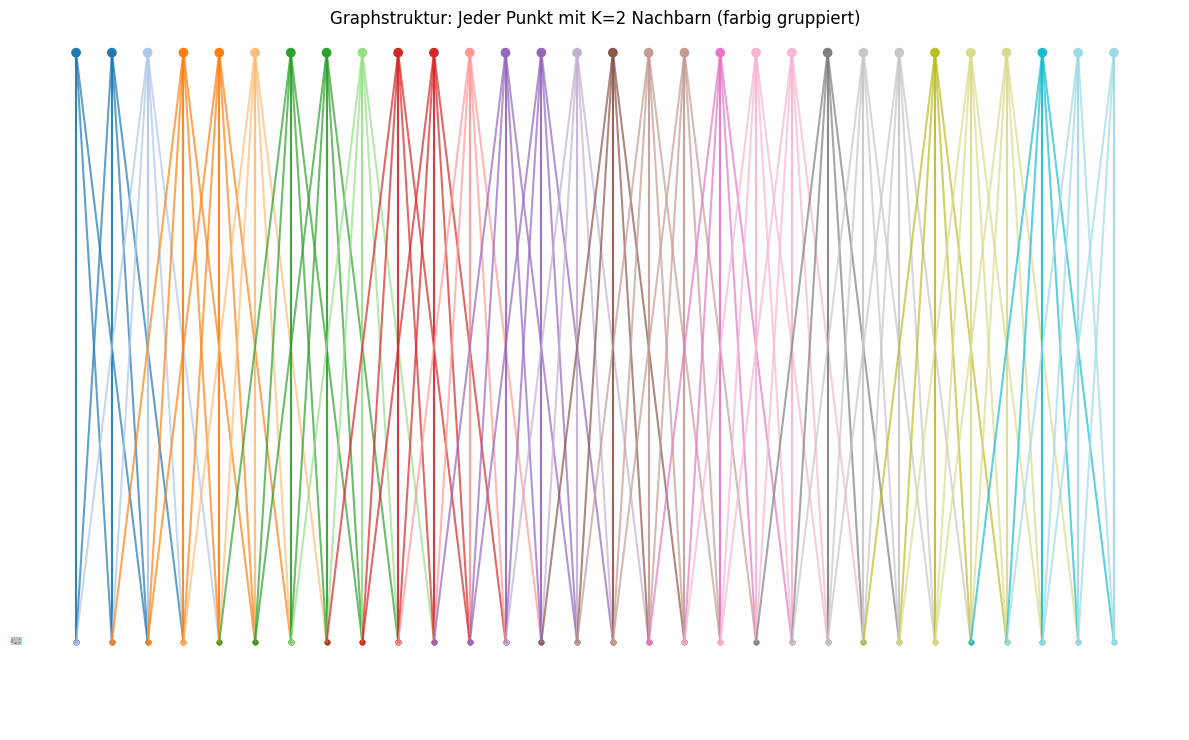

In [ ]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 0.25 * N))
y_gap = 0.3  # engerer vertikaler Abstand

# Farbpalette für die oberen Punkte
colors = cm.get_cmap('tab20', N)  # bis zu 20 eindeutige Farben

# Obere Linie: Gitterknoten
x_pos = x_grid.numpy()
y_top = np.full_like(x_pos, fill_value=y_gap * N)

plt.scatter(x_pos, y_top, color=[colors(i) for i in range(N)], zorder=2)
plt.title(f"Graphstruktur: Jeder Punkt mit K={K} Nachbarn (farbig gruppiert)")
plt.xlabel("x")
plt.axis('off')

# Verbindung zu Nachbarn (unten)
for center in range(N):
    color = colors(center)
    y_row = y_gap
    neighbors = edge_index[1][edge_index[0] == center].tolist()
    for nb in neighbors:
        x1, y1 = x_pos[center], y_top[center]
        x2, y2 = x_pos[nb], y_row
        plt.plot([x1, x2], [y1, y2], color=color, alpha=0.7)
        plt.scatter([x2], [y2], color=color, s=10, zorder=1)

    # Label links der Zeile
    plt.text(-0.2, y_row, f"{center}", verticalalignment='center', fontsize=7, color=color)

# Layout
plt.xlim(x_pos[0] - 0.2, x_pos[-1] + 0.2)
plt.ylim(-1, y_gap * (N + 1))
plt.tight_layout()
plt.show()

In [ ]:
# 5 Remove x coordinate for Generalization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 30           # Anzahl Gitterpunkte
M = 5            # jeder M-te Punkt wird beobachtet
K = 3            # K-Nachbarn
num_epochs = 201
num_samples = 200
lr = 0.01

# Gitterpunkte
x_grid = torch.linspace(0, np.pi, N)

# K-Nachbar-Kanten (mit Self-Loop)
edges = []
for i in range(N):
    edges.append((i, i))  # Self-loop
    for k in range(1, K + 1):
        if i - k >= 0:
            edges.append((i, i - k))
        if i + k < N:
            edges.append((i, i + k))
edge_index = torch.tensor(edges).T  # [2, num_edges]

# GNN-Definition
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        return F.relu(self.self_lin(x) + self.neigh_lin(agg))

class GNN(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden)
        self.gnn1 = GNNLayer(hidden)
        self.gnn2 = GNNLayer(hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.input_proj(x))
        x = self.gnn1(x, edge_index)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)

# Initialisierung
model = GNN(in_dim=2)
opt = torch.optim.Adam(model.parameters(), lr=lr)

# Training
for epoch in range(num_epochs):
    losses = []
    for _ in range(num_samples):
        # Zufällige Sinus- oder Cosinus-Funktion mit Phase
        phase = torch.rand(1).item() * np.pi
        f_type = torch.randint(0, 2, (1,)).item()
        f = lambda x: torch.sin(x + phase) if f_type == 0 else torch.cos(x + phase)
        y_true = f(x_grid)

        # Beobachtung alle M Punkte
        mask = torch.zeros(N)
        mask[::M] = 1.0
        obs_y = y_true * mask

        # Nur [val, mask] als Input
        x_feat = torch.stack([obs_y, mask], dim=1)

        # Training
        model.train()
        pred = model(x_feat, edge_index)
        loss = F.mse_loss(pred, y_true)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {np.mean(losses):.6f}")

Epoch 0: Loss = 0.457707
Epoch 50: Loss = 0.011485
Epoch 100: Loss = 0.008631
Epoch 150: Loss = 0.007629
Epoch 200: Loss = 0.007592


In [ ]:
# Testing Generalization of Graph Networks

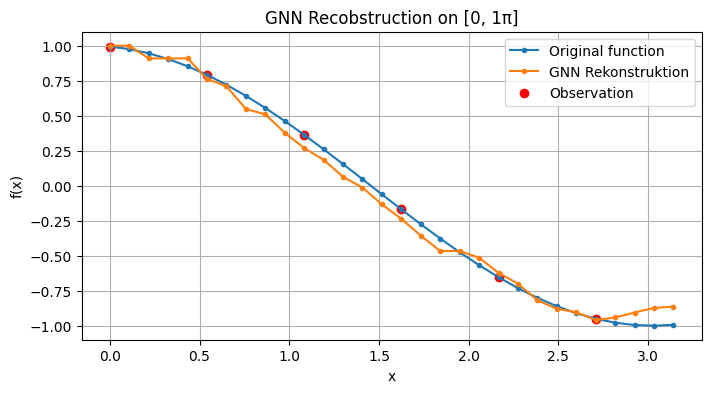

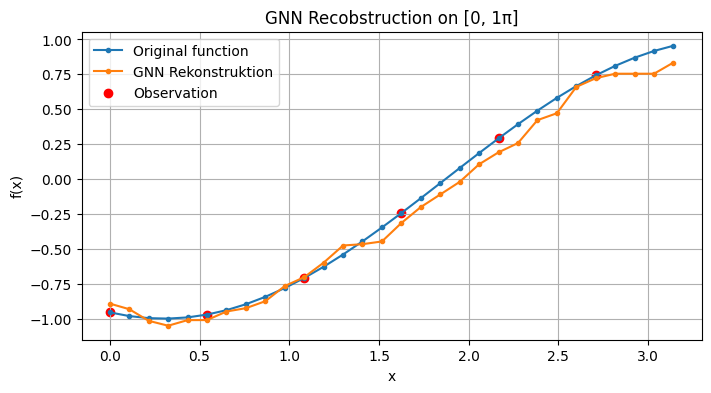

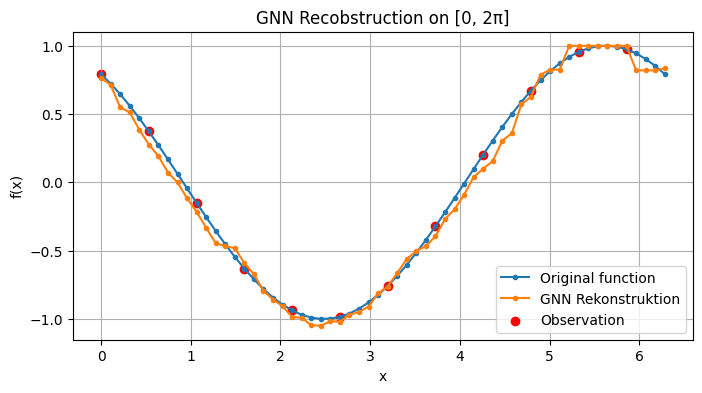

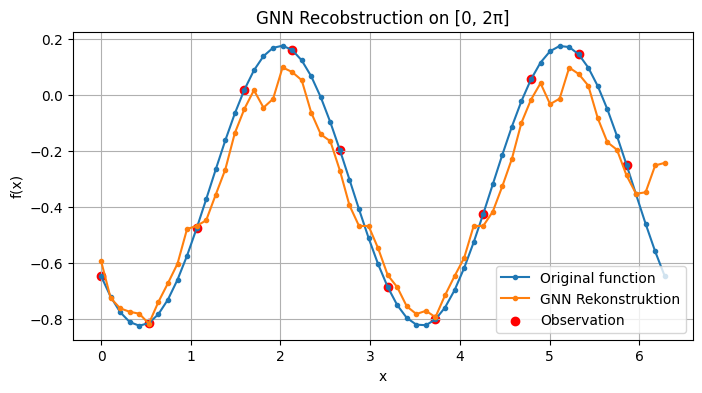

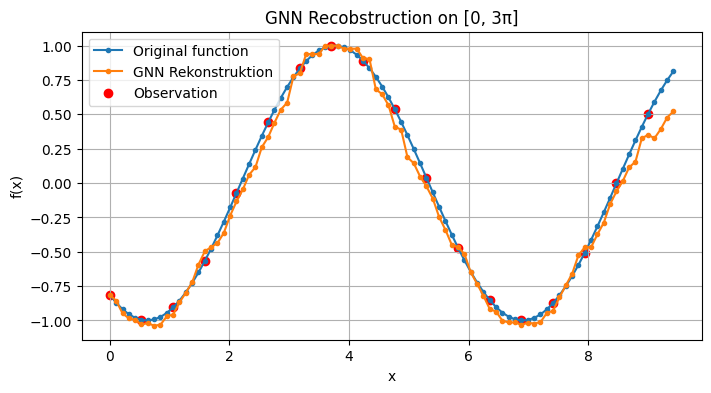

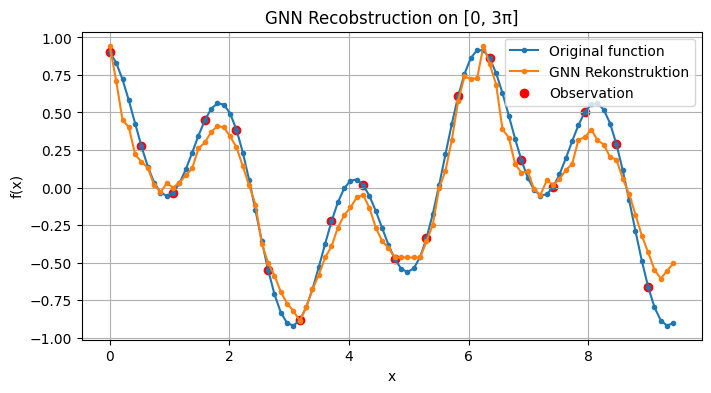

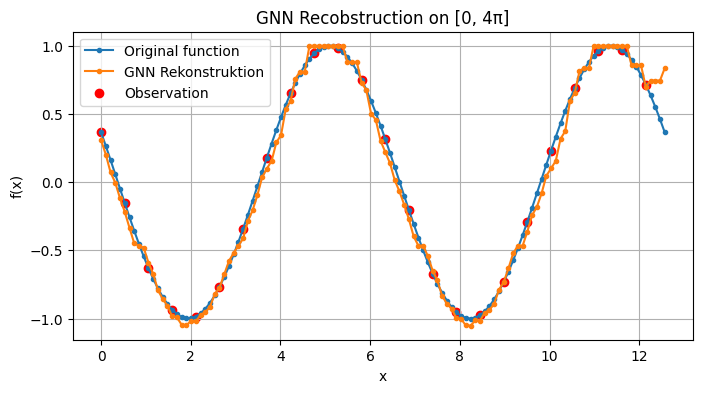

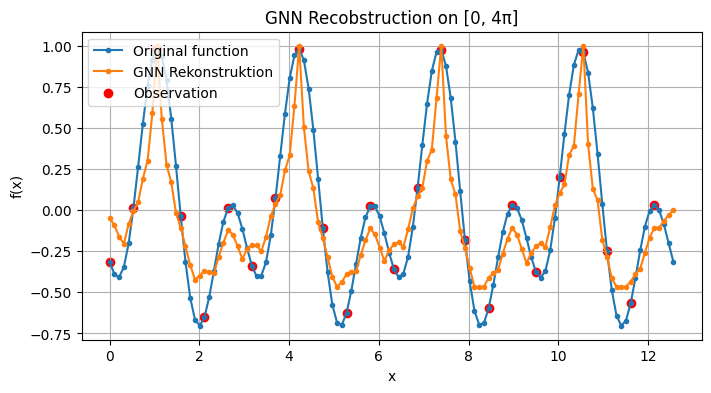

In [ ]:
def run_test(j, jj):
    N_test = jj * 30
    x_test_grid = torch.linspace(0, jj * np.pi, N_test)

    # Neue Testfunktion mit zufälliger Phase
    phi_test = torch.rand(1).item() * np.pi
    f_test = lambda x: torch.cos(x + phi_test) \
        * torch.cos((j-1)*x)
    y_test = f_test(x_test_grid)

    # Beobachtungen nur an jedem M-ten Punkt
    mask = torch.zeros(N_test)
    mask[::M] = 1.0
    obs = y_test * mask
    x_feat_test = torch.stack([obs, mask], dim=1)

    # K-Nachbarn + Self-Loops
    edges = []
    for i in range(N_test):
        edges.append((i, i))  # Self-loop
        for k in range(1, K + 1):
            if i - k >= 0:
                edges.append((i, i - k))
            if i + k < N_test:
                edges.append((i, i + k))
    edge_index_test = torch.tensor(edges).T

    # Vorhersage
    model.eval()
    with torch.no_grad():
        pred_test = model(x_feat_test, edge_index_test)

    # Visualisierung
    plt.figure(figsize=(8, 4))
    plt.plot(x_test_grid, y_test, '.-', label="Original function")
    plt.plot(x_test_grid, pred_test, '.-', label="GNN Rekonstruktion")
    plt.scatter(x_test_grid[::M], y_test[::M], color='red', label="Observation")
    plt.title(f"GNN Recobstruction on [0, {jj}π]")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Anwendung auf zwei Intervalle
for j in range(1,5):
   run_test(1,jj=j)
   run_test(j,jj=j)